<a href="https://colab.research.google.com/github/NicolaRFranco/dlroms/blob/main/Reduced%20order%20modeling%20via%20Deep%20Learning/Deep%20Learning%20based%20ROMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Toy example**: parametrized Burgers Equation

### Setting up the code

In [1]:
# Importing / installing auxiliary libraries
import sys
import os

# DL-ROMs package: a Python library for deep learning based ROMs
try:
     from dlroms import*
except:
     !pip -q install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

# Course source code (auxiliary functions, datasets, etc.)
path = "/content/PredictiveDigitalTwins/Reduced order modeling via Deep Learning/"
if(not os.path.isdir(path)):
  ! git clone --quiet https://github.com/DLROM-hub/PredictiveDigitalTwins.git > /dev/null

sys.path.append(path)
from IPython.display import clear_output as clc
clc()
print("Notebook ready.")

Notebook ready.


## **Continuous model**
Let $\Omega=(0,1)$. We consider the following parameter dependent Burger's equation
</br></br>
$$
\begin{equation}
\tag{1}
\frac{\partial u}{\partial t} + \frac{\partial }{\partial x}\left(\frac{1}{2}u^{2}\right) = \frac{1}{Re}\frac{\partial^{2} u}{\partial x^{2}}
\end{equation}
$$
</br>
complemented with homogenous Dirichlet boundary conditions, and with the following initial condition
</br></br>
$$u(x,0)=\frac{x}{1+e^{-\frac{1}{16}Re\left(1-4x^{2}\right)}},\quad\quad x\in\Omega$$
</br>
We denote by $\boldsymbol{\mu}=[Re, t]$ the (time-extended) vector of parameters. We let $\boldsymbol{\mu}\in[80, 400]\times[0,2]$.

## **Full order model** (FOM solver)
We consider a FOM solver based on the Finite Element method (in space), combined with a Backward Euler scheme (in time). The solver is implemented in the *BurgersFOM.py* module.

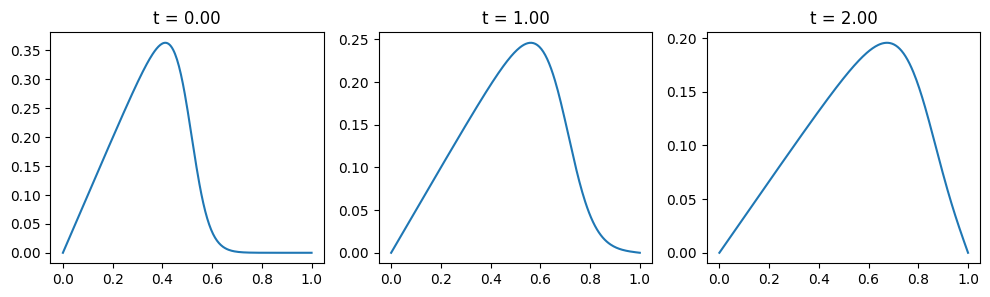

In [2]:
# Example of a single call to the FOM solver
from BurgersFOM import FOMsolver
x, t, u = FOMsolver(Re = 100)
clc()

plt.figure(figsize = (12, 3))
times = 0, 100, 200
for j in range(len(times)):
  plt.subplot(1,3,1+j)
  plot(x, u[times[j]])
  plt.title("t = %.2f" % t[times[j]])

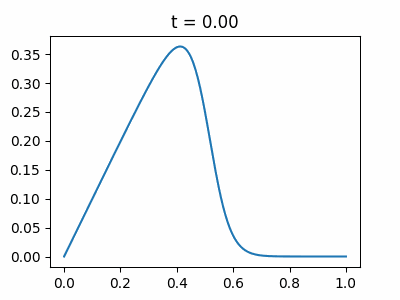

In [3]:
from BurgersFOM import animate
animate(x, t, u)

In [85]:
# Loading FOM simulations
from BurgersFOM import loadData
mu, u = loadData()

# Transfering to Pytorch
mu = CPU.tensor(mu[:50])
u = CPU.tensor(u[:50])

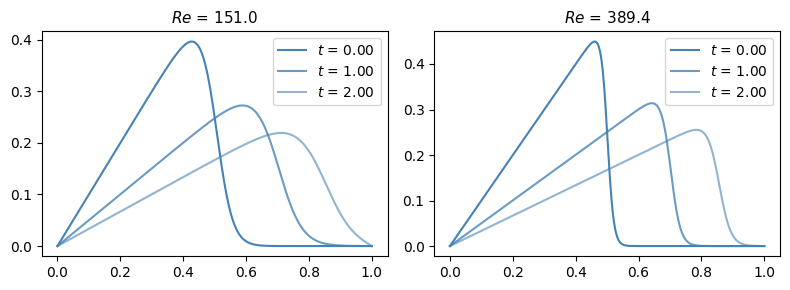

In [11]:
# Let's see some ground truth simulations
which = 5, 4
times = 0, 100, 200
plt.figure(figsize = (8, 3))
for i in range(2):
  for j in range(3):
    plt.subplot(1,2,i+1)
    time = mu[which[i], times[j], 1]
    re = mu[which[i], times[j], 0]
    plot(x, u[which[i], times[j]], label = "$t$ = %.2f" % time, alpha = 1.0-0.2*j, color = 'steelblue')
    plt.title("$Re$ = %.1f" % re, fontsize = 11)
    plt.legend()
plt.tight_layout()

## **Model order reduction** - the POD-NN approach

The idea is to approximate the FOM solution $\mathbf{u}_{\boldsymbol{\mu}}$ as
</br></br>
$$\mathbf{u}_{\boldsymbol{\mu}}^{\text{ROM}}:=\mathbf{V}\phi(\boldsymbol{\mu})\approx \mathbf{u}_{\boldsymbol{\mu}}.$$
</br>
where $\mathbf{V}$ is a matrix representing a suitable basis, while $\phi$ is some function that maps parameters onto basis coefficients. In the POD-NN approach, $\mathbf{V}$ is constructed via Proper Orthogonal Decomposition (POD), while $\phi$ is a neural network, trained such that $\phi(\boldsymbol{\mu})\approx\mathbf{V}^{T}\mathbf{u}_{\boldsymbol{\mu}}$.

### a) Proper Orthogonal Decomposition

In [86]:
# Splitting of the data: we use 80% of the data to design the ROM, and 20% to test its performances
ntrajectories = u.shape[0]
ntimes = u.shape[1]
nsnapshots = ntrajectories*ntimes

ntrain = int(0.8*nsnapshots)
uvect = u.reshape(nsnapshots, -1) # reshaping so that we list all snapshots one by one

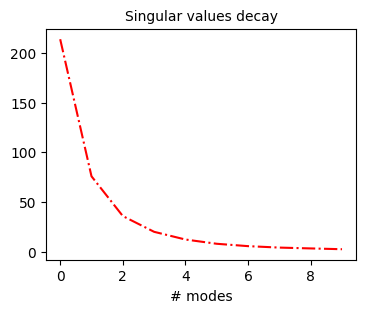

In [87]:
nmodes = 10
basis, eigs = POD(uvect[:ntrain], k = nmodes) # POD basis vectors and corresponding eigenvalues (squared singular values)
# NB: "basis" is a nmodes x nh tensor, that is, basis[k] contains the kth POD mode

svalues = eigs.sqrt() # singular values
plt.figure(figsize = (4,3))
plot(svalues, '-.', color = 'red')
plt.title("Singular values decay", fontsize = 10)
plt.xlabel("# modes")
plt.show()

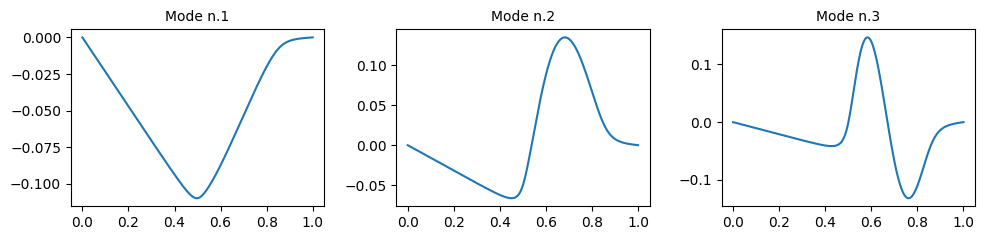

In [89]:
# Let's visualize some of the basis functions
plt.figure(figsize = (10, 2.5))
for j in range(3):
  plt.subplot(1,3,j+1)
  plot(x, basis[j])
  plt.title("Mode n.%d" % (j+1), fontsize = 10)
plt.tight_layout()

In [90]:
# How well does the POD basis represent solutions?
from BurgersFOM import FOMspace
l2 = L2(FOMspace)

utrue = uvect[ntrain:]
V = basis.T
uprojected = utrue.mm(V).mm(V.T) # equivalent to: V.mm(V.T.mm(utrue.T)).T
error = mre(l2)(utrue, uprojected)
print("POD projection error: %s." % num2p(error))

POD projection error: 0.74%.


# b) Learning the POD coordinates

In [91]:
# Projection onto POD coordinates
coeffs = uvect.mm(V) # equivalent to V.T.mm(uvect.T).T

In [141]:
class Normalizer(object):
  def __init__(self, data):
    self.sds = data.var(axis = 0).sqrt().unsqueeze(0)
    self.means = data.mean(axis = 0).unsqueeze(0)

  def __call__(self, x, inverse = False):
    s, m = self.sds, self.means
    return s*x+m if inverse else (x-m)/s

In [142]:
from dlroms.roms import DFNN
p = 2 # total parameters (including time)
muvect = mu.reshape(nsnapshots, p)

# Neural network design and initialization
phi = DFNN(Dense(p, 50) + Dense(50, 50) + Dense(50, nmodes, activation = None))
phi.He()

# Training phase
muNormalizer = Normalizer(muvect[:ntrain])
coeffsNormalizer = Normalizer(coeffs[:ntrain])

normalized_mu = muNormalizer(muvect)
normalized_coeffs = coeffsNormalizer(coeffs)

phi.train(normalized_mu, normalized_coeffs, ntrain = ntrain, epochs = 50, loss = mse(euclidean))
phi.freeze()

		Train		Test
Epoch 50:	5.08e-02	5.63e-02.

>> ETA: 0.34s.

Training complete. Elapsed time: 17.12 seconds.


# c) Assembling the ROM

In [143]:
def ROM(m):
  normalized_m = muNormalizer(m)
  c = phi(normalized_m)
  rescaled_c = coeffsNormalizer(c, inverse = True)
  return rescaled_c.mm(V.T)

# How good is it?
mutrue, utrue = muvect[ntrain:], uvect[ntrain:]
uROM = ROM(mutrue)
ROMerror = mre(l2)(utrue, uROM)
print("POD-NN error: %s." % num2p(ROMerror))

POD-NN error: 1.49%.


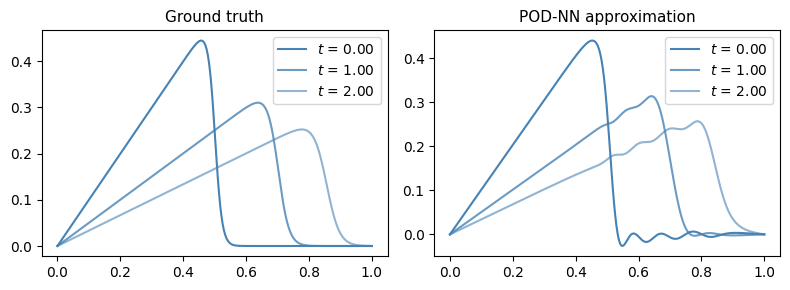

In [144]:
# Visual comparison
Re = 350.0
times = 0, 100, 200
plt.figure(figsize = (8, 3))

x, t, uFOM = FOMsolver(Re)
mu0 = CPU.zeros(ntimes, 2)
mu0[:,0] = Re
mu0[:,1] = CPU.tensor(t)
u0ROM = ROM(mu0)

for j in range(3):
  plt.subplot(1,2,1)
  time = t[times[j]]
  plot(x, uFOM[times[j]], label = "$t$ = %.2f" % time, alpha = 1.0-0.2*j, color = 'steelblue')
  plt.title("Ground truth", fontsize = 11)
  plt.legend()
  plt.subplot(1,2,2)
  plot(x, u0ROM[times[j]], label = "$t$ = %.2f" % time, alpha = 1.0-0.2*j, color = 'steelblue')
  plt.title("POD-NN approximation", fontsize = 11)
  plt.legend()
plt.tight_layout()

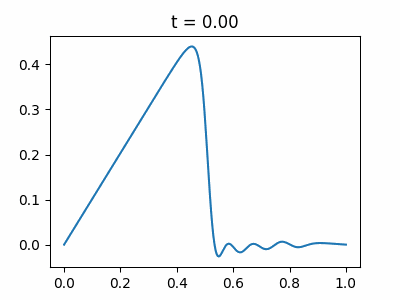

In [145]:
# ROM dynamics
animate(x, t, u0ROM)

## **Model order reduction** - the POD-DL-ROM approach

Another approach is to follow the DL-ROM paradigm, where the "encoding" and "decoding" performed by the POD projector are replaced by two neural networks: an encoder $\Psi'$ and a decoder $\Psi$, respectively. In particular, the DL-ROM approach is based on a representation of the form
</br>
</br>
$$\mathbf{u}_{\boldsymbol{\mu}}\approx\Psi(\phi(\boldsymbol{\mu}))$$
</br>
</br>
with $\phi:\mathbb{R}^{p}\to\mathbb{R}^{n}$ the "reduced map" and $\Psi:\mathbb{R}^{n}\to\mathbb{R}^{N_{h}}$ a "decoder". The encoder module is only exploited during training to impose a form  of *latent regularization*. The three networks, in fact, are trained simultaneously according the loss function below
</br>
</br>
$$\mathcal{L}(\phi,\Psi,\Psi')=\lambda\mathbb{E}\|\mathbf{u}_{\boldsymbol{\mu}}-\Psi(\phi(\boldsymbol{\mu}))\|^{2} + (1-\lambda)\mathbb{E}|\Psi'(\boldsymbol{\mu})-\phi(\boldsymbol{\mu})|^{2}.$$
</br>
</br>
The most delicate part concerns the design of the architectures. For instance, in the POD-DL-ROM approach, one relies on POD-enhanced autoencoders.

In [224]:
### Architectures design
latent = nmodes
varphi = Dense(p, 50) + Dense(50, latent)


newcoeffs = uvect.mm(pod.T)
newcoeffs = Normalizer(newcoeffs[:ntrain])(newcoeffs)

decoder = Dense(latent, 50) + Dense(50, 50) + Dense(50, pod.shape[0], activation = None)
encoder = Dense(pod.shape[0], 50) + Dense(50, latent)
dlrom = DLROM(varphi, decoder, encoder)
dlrom.He()

In [225]:
### Training phase

def loss(true, output):
  # During training, the dlrom takes both mu and u as input, and returns three outputs:
  # 1. decoder(phi(mu)), i.e. the actual prediction
  # 2. phi(mu) - encoder(i), i.e. the difference between the latent representations
  # 3. decoder(encoder(u)), i.e. the autoencoder reconstruction
  predicted, latent_delta, reconstruction = output
  loss1 = mse(euclidean)(true, predicted)/pod.shape[0]
  loss2 = mse(euclidean)(latent_delta, 0)/latent
  return 0.5*loss1 + 0.5*loss2

def error(true, output):
  predicted, latent_delta, reconstruction = output
  return mse(euclidean)(true, predicted)

dlrom.train((normalized_mu, newcoeffs), newcoeffs, ntrain = ntrain, epochs = 300, loss = loss, error = error)

# NB: to speed up the training process, consider switching to GPU. To do so, change all CPU.tensor(...) calls with GPU.tensor(...)
# and make sure to run the command "dlrom.cuda()" before training.
# Remember also to allow GPU usage in Colab: Runtime -> Change runtime type -> GPU.

		Train		Test
Epoch 300:	8.19e-02	1.33e-01.

>> ETA: 0.55s.

Training complete. Elapsed time: 2 minutes 44.59 seconds.


In [226]:
### Online phase
dlrom.freeze()
outNormalizer = Normalizer(uvect.mm(pod.T)[:ntrain])
def dlROM(m):
  return outNormalizer(dlrom(muNormalizer(m)), inverse = True).mm(pod)

# How good is it?
mutrue, utrue = muvect[ntrain:], uvect[ntrain:]
uROM = dlROM(mutrue)
ROMerror = mre(l2)(utrue, uROM)
print("POD-DL-ROM error: %s." % num2p(ROMerror))

POD-DL-ROM error: 1.10%.


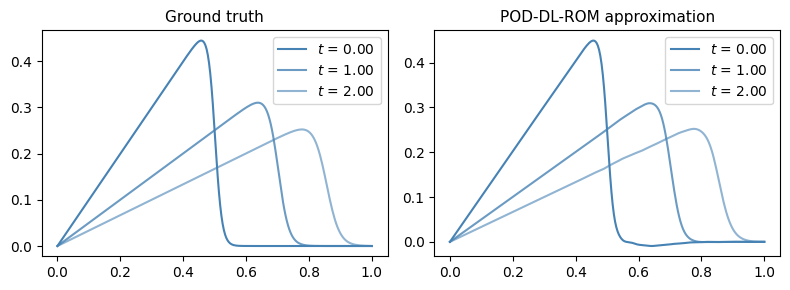

In [227]:
# Visual comparison
Re = 350.0
times = 0, 100, 200
plt.figure(figsize = (8, 3))

x, t, uFOM = FOMsolver(Re)
mu0 = CPU.zeros(ntimes, 2)
mu0[:,0] = Re
mu0[:,1] = CPU.tensor(t)
u0ROM = dlROM(mu0)

for j in range(3):
  plt.subplot(1,2,1)
  time = t[times[j]]
  plot(x, uFOM[times[j]], label = "$t$ = %.2f" % time, alpha = 1.0-0.2*j, color = 'steelblue')
  plt.title("Ground truth", fontsize = 11)
  plt.legend()
  plt.subplot(1,2,2)
  plot(x, u0ROM[times[j]], label = "$t$ = %.2f" % time, alpha = 1.0-0.2*j, color = 'steelblue')
  plt.title("POD-DL-ROM approximation", fontsize = 11)
  plt.legend()
plt.tight_layout()

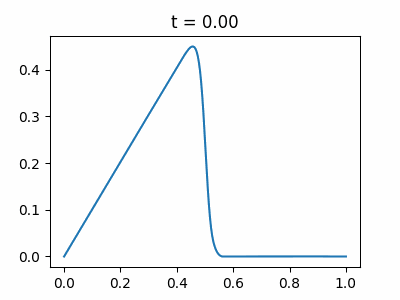

In [230]:
# DL-ROM dynamics
animate(x, t, u0ROM)